# 01_eda

## GiveMeSomeCredit: Exploratory Data Analysis

This notebook provides an exploratory analysis of the GiveMeSomeCredit dataset from a Kaggle competition aimed at understanding credit risk.

For more details, visit the competition page:  
https://www.kaggle.com/c/GiveMeSomeCredit


# Imports

In [1]:
import sys

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

sys.path.append("../../src")
import GiveMeSomeCredit

# Helper Functions

This section contains utility functions that support data processing, analysis, or visualization throughout the notebook. These functions help keep the main workflow organized and reusable.


## Utilities

This section includes general-purpose utility functions that assist with common tasks such as identifying data types, formatting, or other reusable operations used throughout the notebook.


### `get_integer_columns`

Helper function to identify and return all integer-type columns from a DataFrame.


In [2]:
def get_integer_columns(df):
    return list(filter(
        lambda column: pd.api.types.is_integer_dtype(df[column]),
        df.columns
    ))

### `get_float_columns`

Helper function to identify and return all float-type columns from a DataFrame.


In [3]:
def get_float_columns(df):
    return list(filter(
        lambda column: pd.api.types.is_float_dtype(df[column]),
        df.columns
    ))

### `get_value_counts`

Helper function to compute and return sorted value counts for a specified DataFrame column, with optional normalization.


In [4]:
def get_value_counts(df, column, normalize=False):
    return df[column].value_counts(normalize=normalize).sort_index()

## Visualization Functions

Helper functions to generate plots and charts for data exploration and presentation.


### `plot_train_test_distributions`

Helper function to plot and compare the distribution of a specified column in both training and test DataFrames. Supports normalized proportions or raw counts.


In [5]:
def plot_train_test_distributions(train_df, test_df, column, normalize=False, ax=None):
    train_counts = get_value_counts(train_df, column, normalize)
    test_counts = get_value_counts(test_df, column, normalize)
    
    all_indexes = sorted(
        set(train_counts.index).union(set(test_counts.index))
    )
    all_indexes = np.arange(all_indexes[0], all_indexes[-1]+1)
    
    train_counts = train_counts.reindex(all_indexes, fill_value=0)
    test_counts = test_counts.reindex(all_indexes, fill_value=0)

    bar_width = 0.4
    x = np.arange(len(all_indexes))
    
    ax_is_none = ax is None
    if ax_is_none:
        fig, ax = plt.subplots(figsize=(9, 4))

    ax.bar(
        x-bar_width/2, train_counts, width=bar_width,
        label="Train", color="tab:blue", edgecolor="black"
    )
    ax.bar(
        x+bar_width/2, test_counts, width=bar_width,
        label="Test", color="tab:orange", edgecolor="black"
    )
    
    ax.set_title(f"Distribution of {column}")
    ax.set_xlabel(column)
    ax.set_ylabel("Proportion" if normalize else "Count")
    ax.set_xticks(x)
    ax.set_xticklabels(all_indexes, rotation=45)
    ax.legend()
    
    if ax_is_none:
        plt.tight_layout()
        plt.show()

### `plot_train_test_histogram`

Helper function to plot overlaid histograms comparing the distribution of a numeric column in training and test DataFrames, with optional normalization.


In [6]:
def plot_train_test_histogram(train_df, test_df, column, bins=30, ax=None, normalize=False):
    train_data = train_df[column].dropna()
    test_data = test_df[column].dropna()

    combined_min = np.min([train_data.min(), test_data.min()])
    combined_max = np.max([train_data.max(), test_data.max()])

    bin_edges = np.linspace(combined_min, combined_max, bins + 1)
    
    train_counts, _ = np.histogram(train_data, bins=bin_edges)
    test_counts, _ = np.histogram(test_data, bins=bin_edges)

    if normalize:
        train_counts = train_counts / train_counts.sum()
        test_counts = test_counts / test_counts.sum()

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bar_width = (bin_edges[1] - bin_edges[0]) * 0.4

    ax_is_none = ax is None
    if ax_is_none:
        fig, ax = plt.subplots(figsize=(9, 4))

    ax.bar(
        bin_centers - bar_width/2, train_counts, width=bar_width,
        label="Train", color="tab:blue", edgecolor="black"
    )
    ax.bar(
        bin_centers + bar_width/2, test_counts, width=bar_width,
        label="Test", color="tab:orange", edgecolor="black"
    )

    ax.set_title(f"Histogram of {column}")
    ax.set_xlabel(column)
    ax.set_ylabel("Proportion" if normalize else "Count")
    ax.legend()
    
    if ax_is_none:
        plt.tight_layout()
        plt.show()

### `plot_train_test_boxplot`

Helper function to create side-by-side horizontal boxplots comparing the distribution of a numeric column in training and test DataFrames.


In [7]:
def plot_train_test_boxplot(train_df, test_df, column, showfliers=True, ax=None):
    data = [test_df[column].dropna(), train_df[column].dropna()]
    labels = ["Test", "Train"]
    colors = ["tab:orange", "tab:blue"]

    ax_is_none = ax is None
    if ax_is_none:
        fig, ax = plt.subplots(figsize=(9, 4))

    bp = ax.boxplot(
        data, vert=False, patch_artist=True,
        medianprops=dict(color="black"),
        whiskerprops=dict(color="black"),
        capprops=dict(color="black"),
        flierprops=dict(
            marker="o", markerfacecolor="red", markersize=5,
            linestyle="none", markeredgecolor="black"
        ),
        showfliers=showfliers
    )
    
    for patch, color in zip(bp["boxes"], colors):
        patch.set_facecolor(color)

    ax.set_yticks([1, 2])
    ax.set_yticklabels(labels)

    ax.set_title(f"Boxplot of {column}")
    ax.set_xlabel(column)
    ax.grid(axis="x", alpha=0.7)

    if ax_is_none:
        plt.tight_layout()
        plt.show()


### `plot_correlation_matrix`

Helper function to plot a correlation matrix heatmap of numeric features in a DataFrame, with correlation values annotated on the cells.


In [8]:
def plot_correlation_matrix(df, title=None, ax=None, highlight_threshold=0.3):
    correlation_matrix = df.select_dtypes(include=[np.number]).corr()
    labels = correlation_matrix.columns.tolist()
    x_ticks = np.arange(len(labels))
    
    ax_is_none = ax is None
    if ax_is_none:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    cax = ax.matshow(correlation_matrix, cmap="coolwarm", vmin=-1, vmax=1)
    
    norm = plt.Normalize(vmin=-1, vmax=1)
    cmap = plt.get_cmap("coolwarm")
    
    for ii in range(len(labels)):
        for jj in range(len(labels)):
            value = correlation_matrix.iloc[ii, jj]
            color_value = norm(value)
            background_color = cmap(color_value)
            luminance = 0.299 * background_color[0] + 0.587 * background_color[1] + 0.114 * background_color[2]
            text_color = "black" if luminance > 0.5 else "white"

            if abs(value) >= highlight_threshold and ii != jj:
                ax.text(jj, ii, f"{value:.2f}", va="center", ha="center", color=text_color, fontweight="bold")
            else:
                ax.text(jj, ii, f"{value:.2f}", va="center", ha="center", color=text_color, alpha=0.7)

    ax.set_xticks(x_ticks)
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.xaxis.set_ticks_position("bottom")

    ax.set_yticks(x_ticks)
    ax.set_yticklabels(labels)

    fig.colorbar(cax)
    if title:
        ax.set_title(title)
    plt.tight_layout()
    plt.show()


### `plot_integer_distributions`

Helper function to plot distribution comparisons for all integer columns in the training and test datasets.


In [9]:
def plot_integer_distributions(train_df, test_df, max_bins=30, bins=30, normalize=True):
    columns = get_integer_columns(train_df)
    for column in columns:
        min_value = min(train_df[column].min(), test_df[column].min())
        max_value = max(train_df[column].max(), test_df[column].max())
        
        if max_value - min_value + 1 > max_bins:
            plot_train_test_histogram(
                train_df, test_df, column, bins=bins, normalize=normalize
            )
        else:
            plot_train_test_distributions(
                train_df, test_df, column, normalize=normalize
            )

### `plot_float_distributions`

Helper function to plot histogram comparisons for all float columns in the training and test datasets.


In [10]:
def plot_float_distributions(train_df, test_df, bins=30, normalize=True):
    float_columns = get_float_columns(train_df)
    for column in float_columns:
        plot_train_test_histogram(
            train_df, test_df, column, bins=bins, normalize=normalize
        )

### `plot_box_and_whisker`

Helper function to create boxplots comparing distributions of all numeric columns between training and test datasets.


In [11]:
def plot_box_and_whisker(train_df, test_df):
    numeric_columns = train_df.select_dtypes(include=["number"]).columns.tolist()
    for column in numeric_columns:
        plot_train_test_boxplot(train_df, test_df, column)

# Data Loading

## Loading the Training Dataset

This section loads the training data into a DataFrame and displays its basic information.


In [12]:
train_df = GiveMeSomeCredit.load_training_data()

/Users/rina/llm-classification/data/GiveMeSomeCredit/raw/cs-training.csv Memory Usage: 13.73 MB


,dtype,count,non_null,null_count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,int64,150000,150000,0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,float64,150000,150000,0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
age,int64,150000,150000,0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,int64,150000,150000,0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,float64,150000,150000,0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
MonthlyIncome,float64,120269,120269,29731,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,int64,150000,150000,0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,int64,150000,150000,0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,int64,150000,150000,0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,int64,150000,150000,0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149996,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149997,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149998,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149999,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


## Loading the Test Dataset

This section loads the test data into a DataFrame and displays its basic information.


In [13]:
test_df = GiveMeSomeCredit.load_testing_data()

/Users/rina/llm-classification/data/GiveMeSomeCredit/raw/cs-test.csv Memory Usage: 9.29 MB


,dtype,count,non_null,null_count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,float64,0,0,101503,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RevolvingUtilizationOfUnsecuredLines,float64,101503,101503,0,5.310000,196.156039,0.0,0.030131,0.152586,0.564225,21821.0
age,int64,101503,101503,0,52.405436,14.779756,21.0,41.000000,52.000000,63.000000,104.0
NumberOfTime30-59DaysPastDueNotWorse,int64,101503,101503,0,0.453770,4.538487,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,float64,101503,101503,0,344.475020,1632.595231,0.0,0.173423,0.364260,0.851619,268326.0
MonthlyIncome,float64,81400,81400,20103,6855.035590,36508.600375,0.0,3408.000000,5400.000000,8200.000000,7727000.0
NumberOfOpenCreditLinesAndLoans,int64,101503,101503,0,8.453514,5.144100,0.0,5.000000,8.000000,11.000000,85.0
NumberOfTimes90DaysLate,int64,101503,101503,0,0.296691,4.515859,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,int64,101503,101503,0,1.013074,1.110253,0.0,0.000000,1.000000,2.000000,37.0
NumberOfTime60-89DaysPastDueNotWorse,int64,101503,101503,0,0.270317,4.503578,0.0,0.000000,0.000000,0.000000,98.0


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
4,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
5,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
101499,NaN,0.282653,24,0,0.068522,1400.0,5,0,0,0,0.0
101500,NaN,0.922156,36,3,0.934217,7615.0,8,0,2,0,4.0
101501,NaN,0.081596,70,0,836.000000,NaN,3,0,0,0,NaN
101502,NaN,0.335457,56,0,3568.000000,NaN,8,0,2,1,3.0


# Exploratory Data Analysis (EDA) Visualizations

This section presents various plots and charts to explore and compare distributions, relationships, and patterns in the training and test datasets.


From these plots, we can see that the integer-valued columns in both the training and test datasets have similar distributions. Some variables (e.g., `NumberOfTime60-89DaysPastDueNotWorse` and `NumberOfTime30-59DaysPastDueNotWorse`) show noticeable outliers, which are further examined in the box-and-whisker plots. Note that the plot for `SeriousDlqin2yrs` appears unusual because the target values are missing in the test dataset.

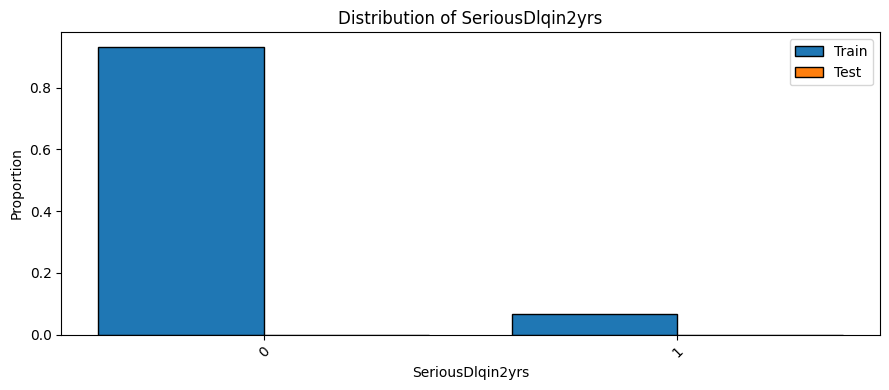

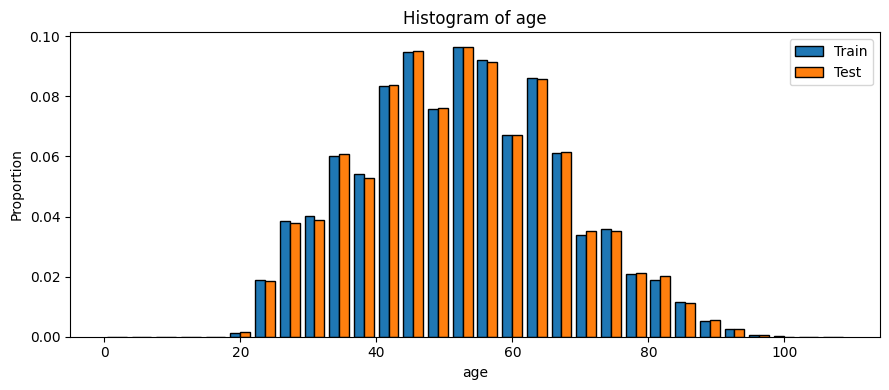

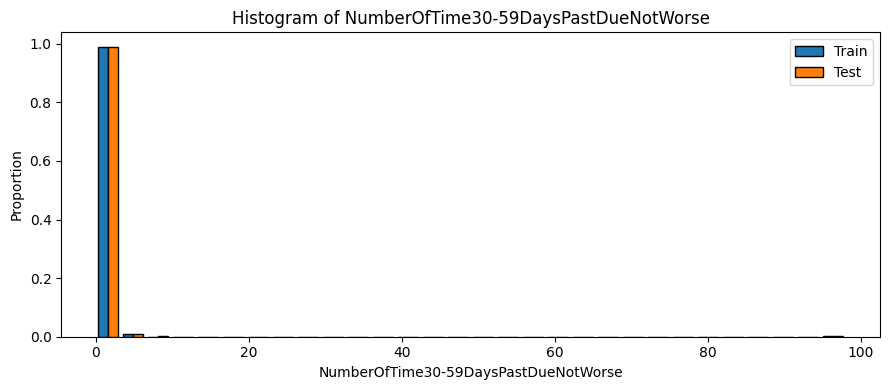

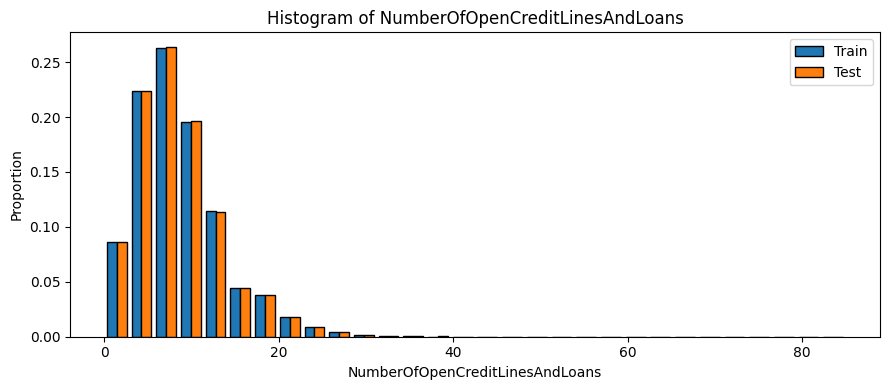

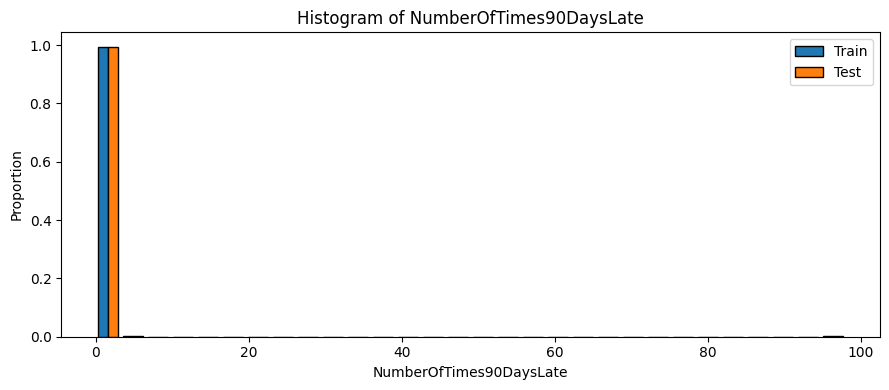

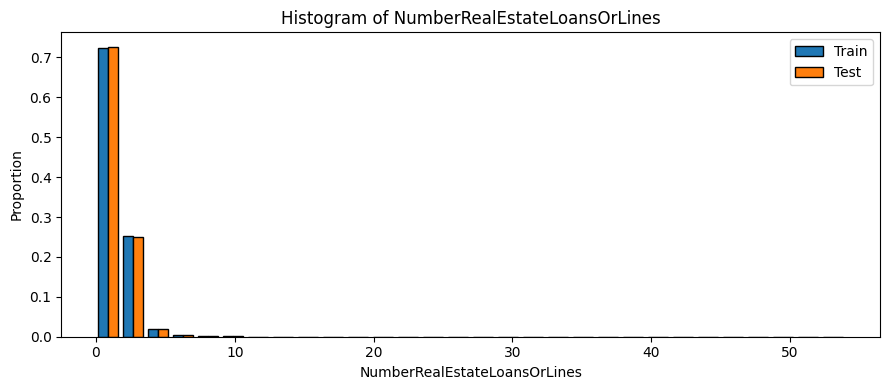

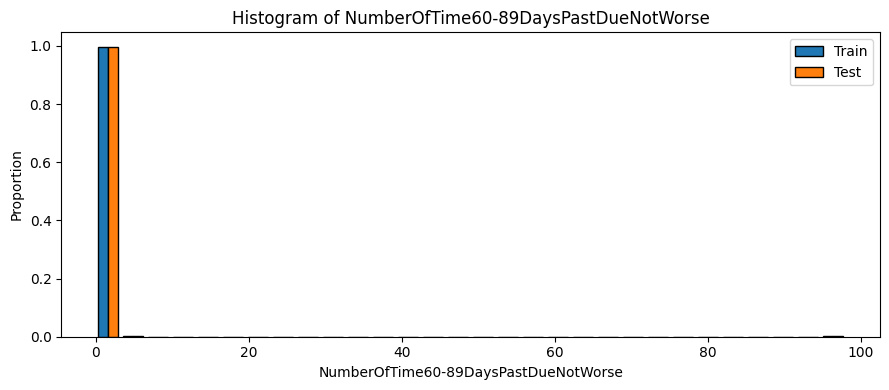

In [14]:
plot_integer_distributions(train_df, test_df, normalize=True)

## Float Feature Distributions

This plot displays histograms comparing the distributions of all float features between the training and test datasets, using 30 bins.

Similar to the integer-valued plots, these plots show that the continuous (real-valued) columns in both the training and test datasets have similar distributions, although some outliers are present.

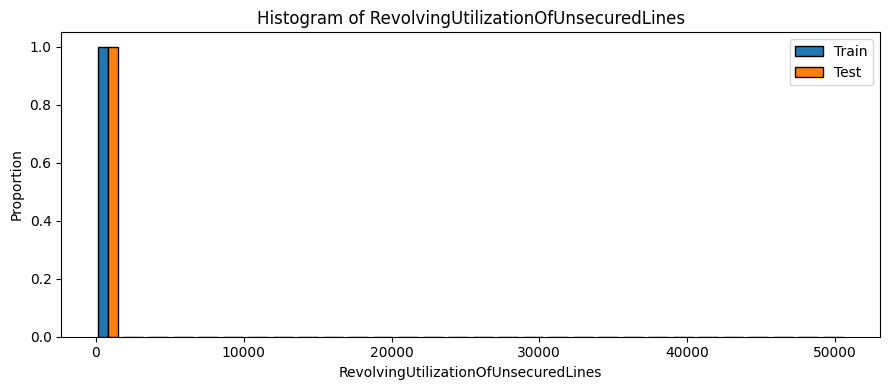

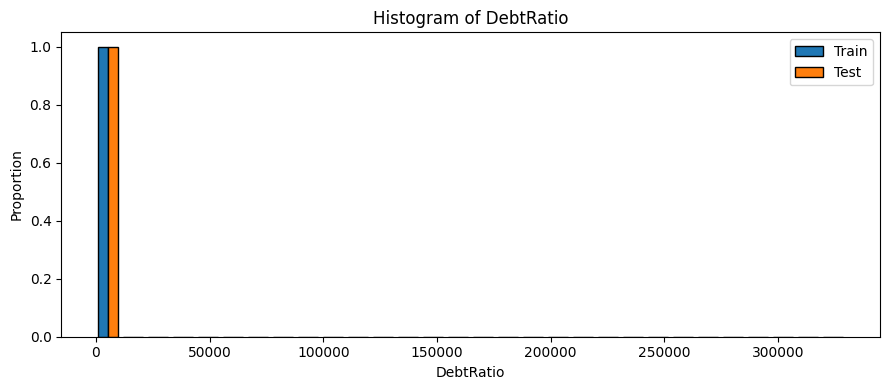

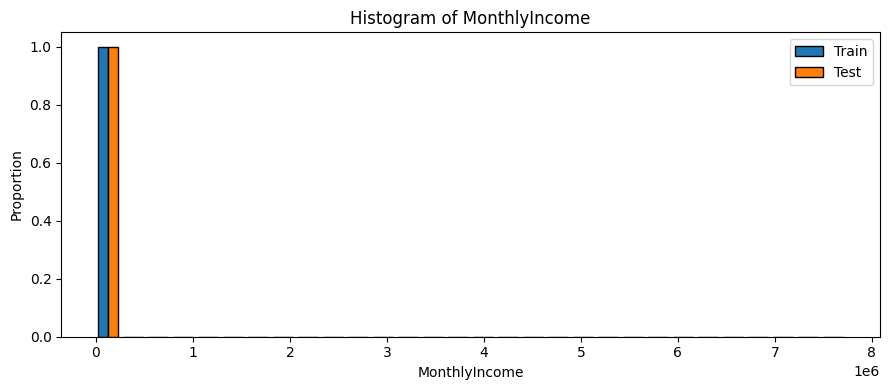

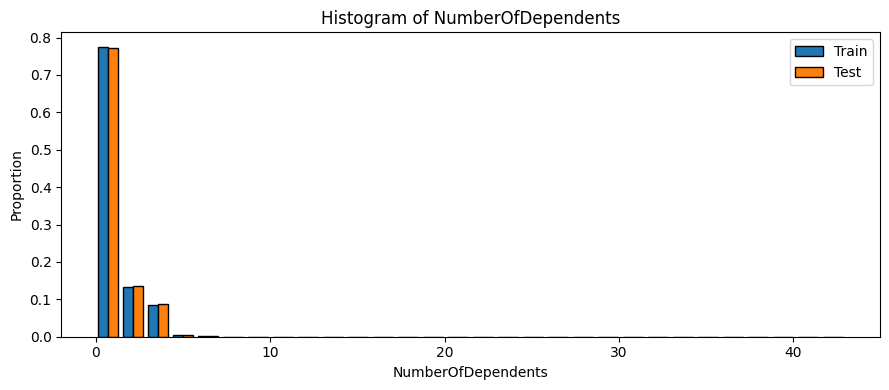

In [15]:
plot_float_distributions(train_df, test_df, bins=30)

## Box and Whisker Plots for Numeric Features

This plot presents side-by-side boxplots to compare the distribution, spread, and outliers of all numeric features in the training and test datasets.

Several of the previous plots showed the presence of extreme outliers; these box-and-whisker plots provide a clearer depiction of them. While some could be cause for concern, they appear in both the training and test datasets, making them less likely to be errors or typos. A few of these outliers may warrant further investigation, but overall the data appears sufficient for our purposes.

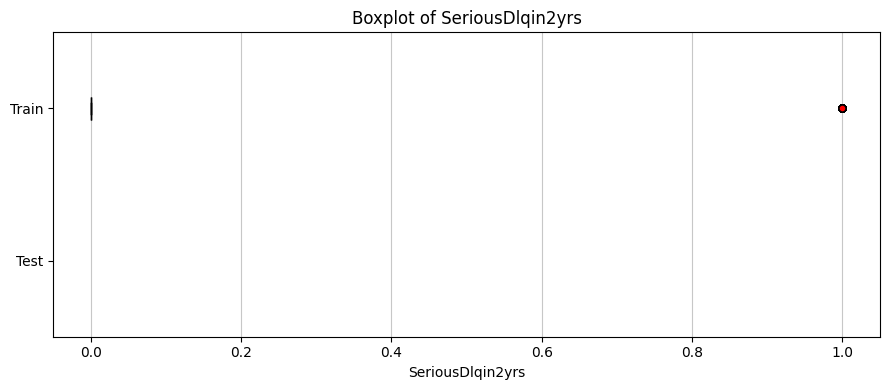

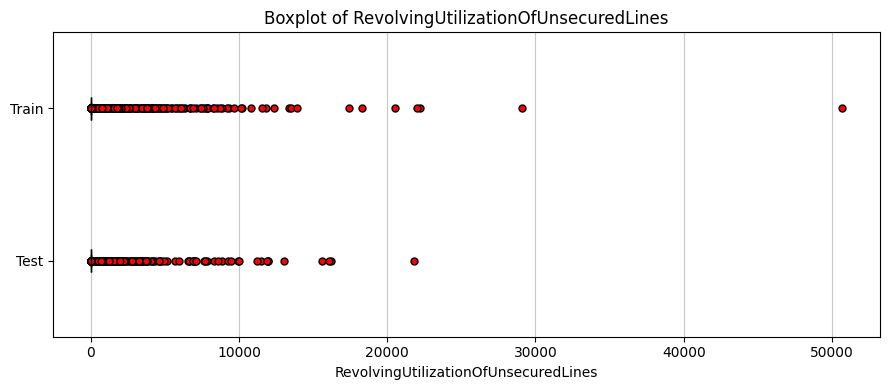

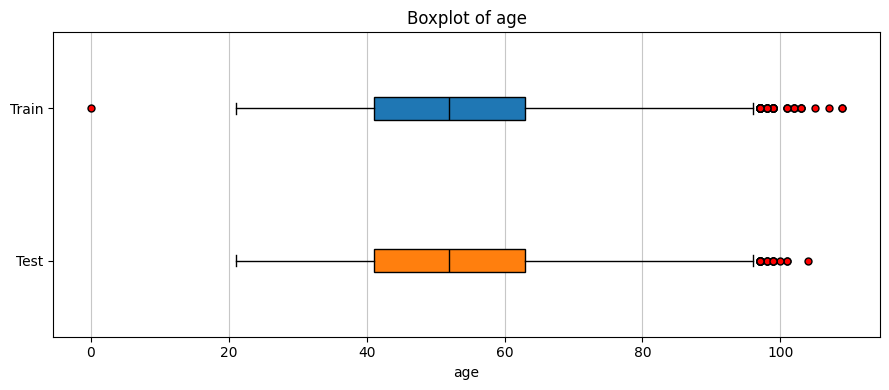

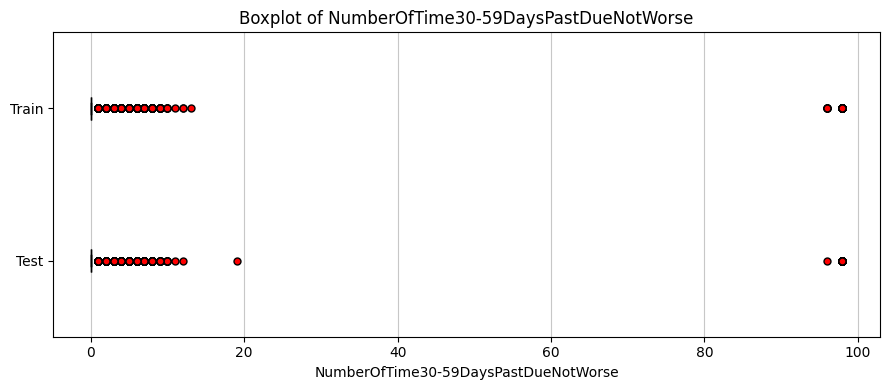

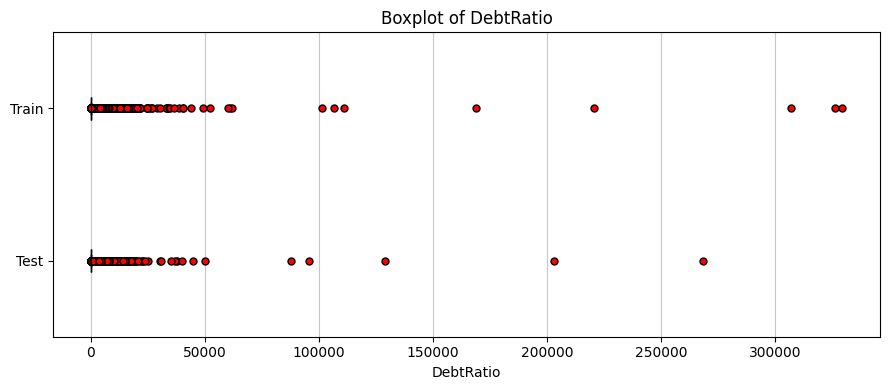

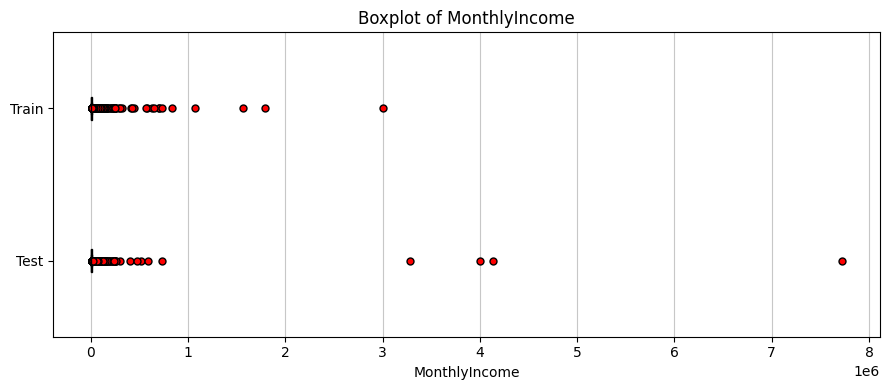

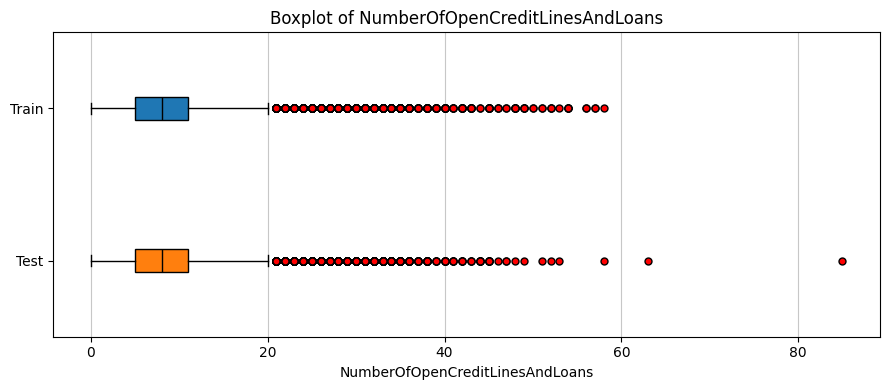

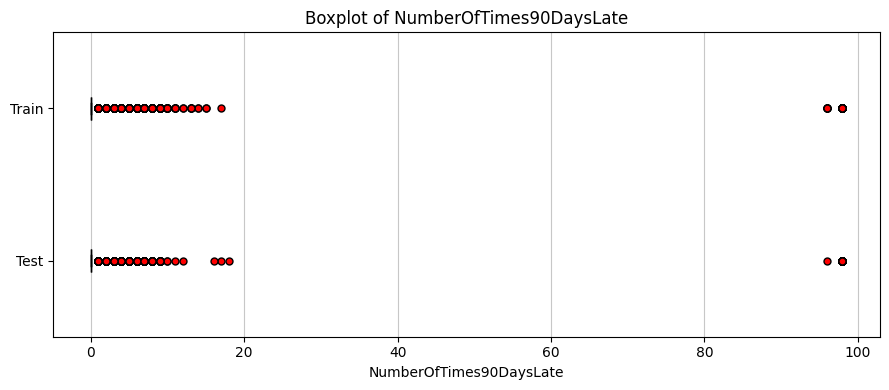

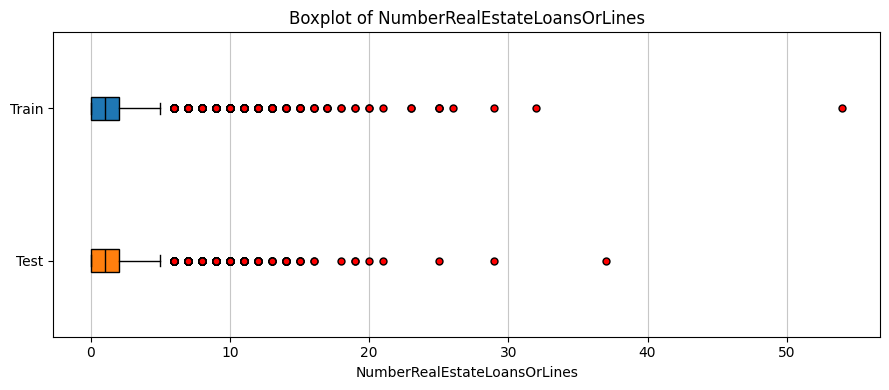

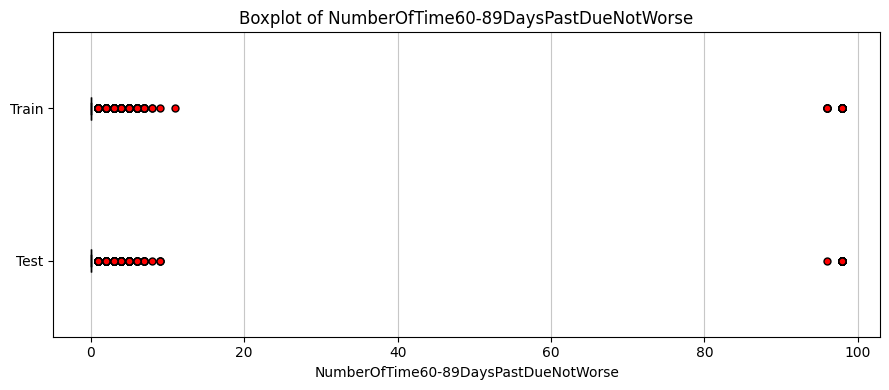

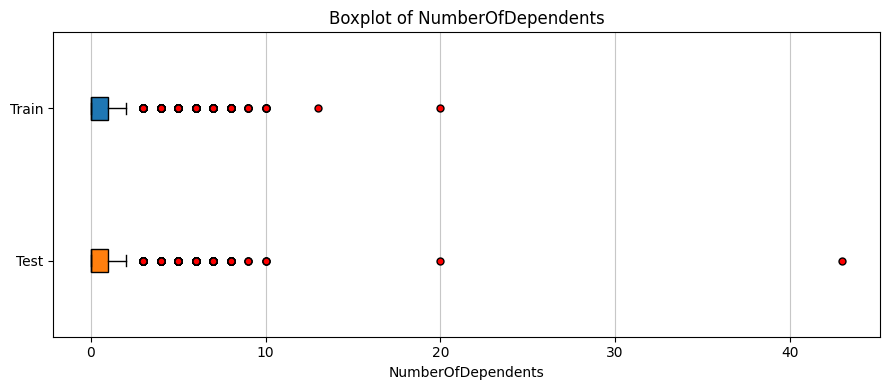

In [16]:
plot_box_and_whisker(train_df, test_df)

## Correlation Matrices

These heatmaps display the pairwise Pearson correlation coefficients among numeric features in the training and test datasets, highlighting potential linear relationships.

Several notable patterns:

* There is a very strong positive correlation among `NumberOfTime30-59DaysPastDueNotWorse`, `NumberOfTime60-89DaysPastDueNotWorse`, and `NumberOfTimes90DaysLate`, which is expected given their similar definitions. Each variable measures related forms of delinquency at different severity levels, so borrowers who are late in one category are often late in others.

* There is a moderate positive correlation between `NumberOfOpenCreditLinesAndLoans` and `NumberRealEstateLoansOrLines`. This occurs because real estate loans are a subset of open credit lines and loans, creating a natural overlap between the two measures.

* There is a weak negative correlation between `age` and `NumberOfDependents`, which reflects the tendency for older borrowers to have fewer dependents on average.

* All other variables, including the target variable, show only weak or negligible correlations.

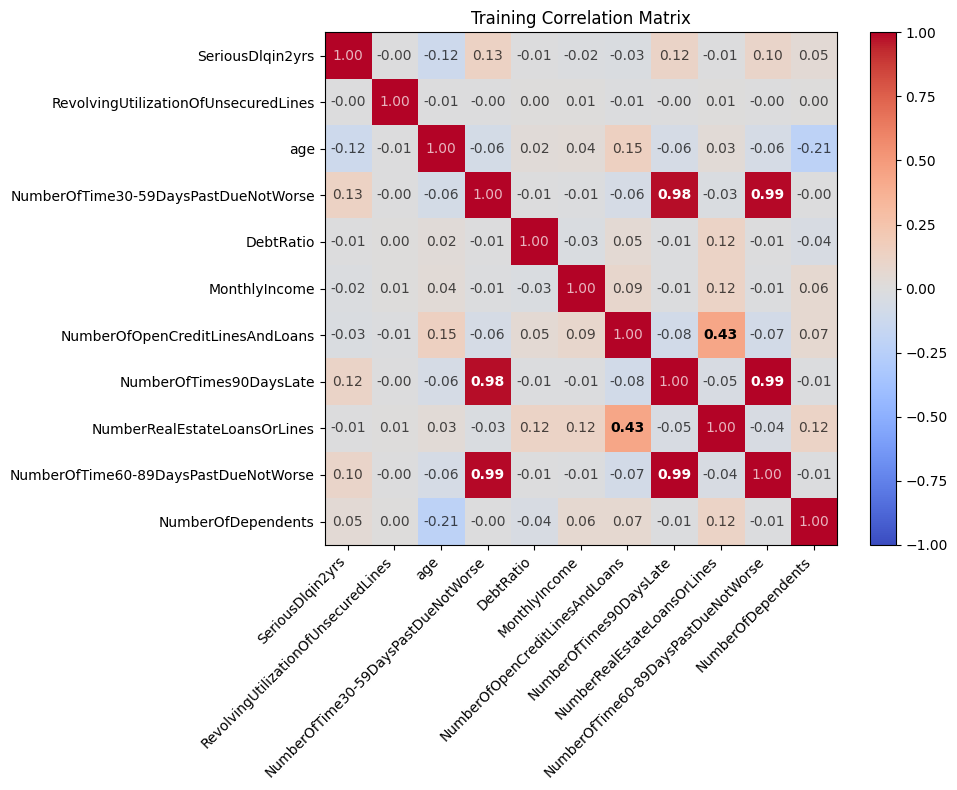

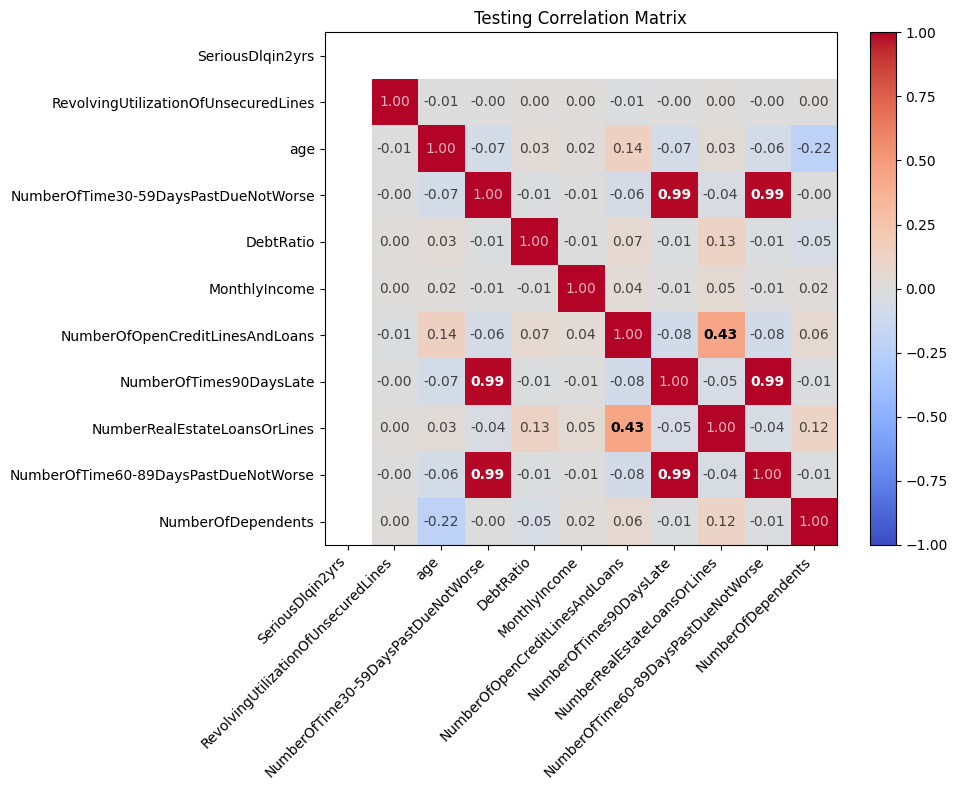

In [17]:
plot_correlation_matrix(train_df, title="Training Correlation Matrix")
plot_correlation_matrix(test_df, title="Testing Correlation Matrix")